<a href="https://colab.research.google.com/github/YuhaiW/00/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


In [47]:
class Discriminator(nn.Module):
  def __init__(self, im_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(im_dim, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

In [48]:
from torch.nn.modules.activation import Tanh
class Generator(nn.Module):
  def __init__(self, z_dim, im_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,im_dim),
        nn.Tanh()
    )
  
  def forward(self,x):
    return self.gen(x)


In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [50]:
lr = 9e-4
z_dim = 64
image_dim = 28*28*1
batch_size = 32
num_epochs = 50


In [51]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
fixed_noise.size()

torch.Size([32, 64])

This code block sets up a PyTorch data loader for the MNIST dataset with a specified batch size and data transformations.

Here's what each line does:

transforms.Compose() creates a series of image transformations to be applied to the dataset. In this case, it includes converting the images to PyTorch tensors with transforms.ToTensor(), and then normalizing the tensor values using the mean (0.13,) and standard deviation (0.3,) of the dataset.

datasets.MNIST() initializes a new MNIST dataset instance with the specified root directory for data storage, and the transform parameter to apply the previously created transformations to the dataset. The download parameter is set to True to download the dataset if it doesn't already exist in the specified root directory.

DataLoader() creates a PyTorch data loader for the dataset with the specified batch size batch_size and shuffles the data with shuffle=True during training to avoid bias in the mini-batches.

In [52]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13,),(0.3,))]
)
dataset = datasets.MNIST(root = "dataset/", transform = transforms, download=True)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [53]:
opt_disc = optim.Adam(params = disc.parameters(), lr = lr)
opt_gen = optim.Adam(params = gen.parameters(), lr = lr)
criterion = nn.BCELoss()
writer_FAKE = SummaryWriter(f"/fake")
writer_REAL = SummaryWriter(f"/real")




In [54]:
step = 0
for epoch in range(10):
  for batch_idX, (real, _) in enumerate(loader):
    real = real.view(-1,784).to(device)
    batch_size = real.shape[0]
    if batch_idX == 0 & epoch == 0:
      print(f"batch_size is{batch_size}!!! ")

    ## Train Discrimiator

    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    loss_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).view(-1)
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_avg = (loss_real+loss_fake)/2
    disc.zero_grad()
    loss_avg.backward(retain_graph=True)
    opt_disc.step()

    ## Train Generator
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idX == 0:
      print(
          f"epoch:{epoch}/{num_epochs}"
          f"LossD: {loss_avg: .4f}, LossG:{lossG:.4f}")
      
      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1,1,28,28)
        data = real.reshape(-1,1,28,28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
        img_grid_real = torchvision.utils.make_grid(data, normalize = True)
        

        writer_FAKE.add_image(
            "Minist Fake Image", img_grid_fake, global_step = step

        )
        writer_FAKE.add_image(
            "Minist real Image", img_grid_real, global_step = step
            
        )
        step += 1
      







batch_size is32!!! 
epoch:0/50LossD:  0.6866, LossG:0.7203
batch_size is32!!! 
epoch:1/50LossD:  0.2906, LossG:2.8460
batch_size is32!!! 
epoch:2/50LossD:  0.1725, LossG:3.0235
batch_size is32!!! 
epoch:3/50LossD:  0.2439, LossG:3.9815
batch_size is32!!! 
epoch:4/50LossD:  0.0992, LossG:3.4520
batch_size is32!!! 
epoch:5/50LossD:  0.0533, LossG:5.7694
batch_size is32!!! 
epoch:6/50LossD:  0.0480, LossG:3.9883
batch_size is32!!! 
epoch:7/50LossD:  0.0218, LossG:5.2959
batch_size is32!!! 
epoch:8/50LossD:  0.0151, LossG:5.0175
batch_size is32!!! 
epoch:9/50LossD:  0.0086, LossG:5.6799


In [55]:
fake = gen(noise)
fake[0].size()


torch.Size([784])

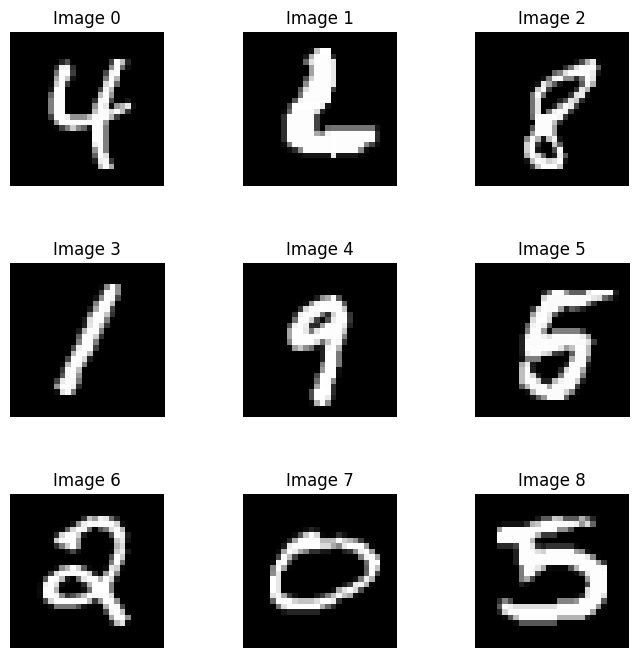

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = real[i].cpu().detach().numpy().reshape(28,28)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()

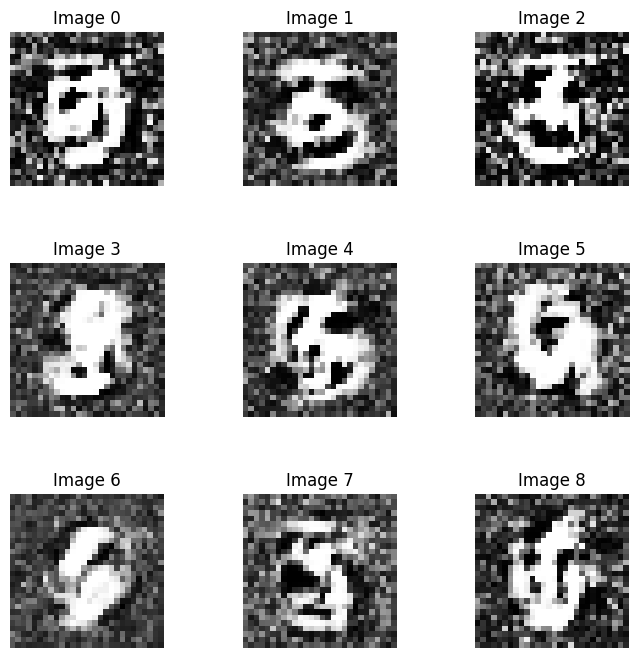

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = fake[i].cpu().detach().numpy().reshape(28,28)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()